In [524]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import math
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

REMEMBER drop entries with 0 total sales!!!!!

In [525]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/"
# parent directory
# parent_dir = Path.cwd().parent

# path to the dataset
# data_path = os.path.join(parent_dir ,'data','raw','weekly-train-1.csv')

# reading a CSV file into a DataFrame
df_train = pd.read_csv(drive_path+'weekly-train-1.csv')
df_test = pd.read_csv(drive_path+'weekly-test-1.csv')

df_train = df_train[df_train['TOTAL_SALES'] > 0]

df_train['set'] = 'train'
df_test['set'] = 'test'
df_test['TOTAL_SALES'] = np.nan

# concatenate for consistent feature engineering on both datasets
df = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [526]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,True,False,True,False,False,False,False,False,False,False,False,False,train
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,True,False,True,False,False,False,False,False,False,False,False,False,train
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,False,False,False,False,train
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,False,False,False,False,train
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,True,False,False,False,False,False,False,False,False,False,train


In [527]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRODUCT_DESC          1405 non-null   object 
 1   PRODUCT_ID            1405 non-null   int64  
 2   DATE                  1405 non-null   object 
 3   TOTAL_SALES           989 non-null    float64
 4   PRICE                 1405 non-null   float64
 5   IS_COUPON             1405 non-null   bool   
 6   IS_DISPLAY            1405 non-null   bool   
 7   IS_FEATURE            1405 non-null   bool   
 8   IS_PROMO              1405 non-null   bool   
 9   IS_INDEPENDENCE_DAY   1405 non-null   bool   
 10  IS_PRE_CHRISTMAS      1405 non-null   bool   
 11  IS_SUPER_BOWL_SUNDAY  1405 non-null   bool   
 12  IS_PRE_THANKSGIVING   1405 non-null   bool   
 13  IS_EASTER_SUNDAY      1405 non-null   bool   
 14  IS_LABOR_DAY          1405 non-null   bool   
 15  IS_MEMORIAL_DAY      

In [528]:
# notice how 'tot_sales' minimum value is 0, which could be a problem for MAPE calculation
df.describe()

,PRODUCT_ID,TOTAL_SALES,PRICE
count,1.405000e+03,989.000000,1405.000000
mean,1.834992e+11,11065.805785,6.200888
std,3.244396e+11,9287.676139,1.629093
min,3.450014e+09,1628.913015,2.692734
25%,3.450015e+09,5228.798606,4.999980
50%,3.450015e+09,7633.006153,5.715059
75%,3.450015e+09,15626.911843,6.573549
max,7.677070e+11,45877.859803,10.502462


In [529]:
df.shape

(1405, 19)

In [530]:
# checking for missing values in the DataFrame
df.isnull().sum()

,0
PRODUCT_DESC,0
PRODUCT_ID,0
DATE,0
TOTAL_SALES,416
PRICE,0
IS_COUPON,0
IS_DISPLAY,0
IS_FEATURE,0
IS_PROMO,0
IS_INDEPENDENCE_DAY,0


In [531]:
# checking the data types of each column in the DataFrame
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

PRODUCT_DESC: object
PRODUCT_ID: int64
DATE: object
TOTAL_SALES: float64
PRICE: float64
IS_COUPON: bool
IS_DISPLAY: bool
IS_FEATURE: bool
IS_PROMO: bool
IS_INDEPENDENCE_DAY: bool
IS_PRE_CHRISTMAS: bool
IS_SUPER_BOWL_SUNDAY: bool
IS_PRE_THANKSGIVING: bool
IS_EASTER_SUNDAY: bool
IS_LABOR_DAY: bool
IS_MEMORIAL_DAY: bool
IS_THANKSGIVING: bool
IS_CHRISTMAS_DAY: bool
set: object


In [532]:
# converting the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].dtype.name)

datetime64[ns]


## Feature Engineering
Re-arranging some features in order to be able to extract useful information

### Holiday Features
Those are boolean features that can be left as they are, since XGBoost automatically converts them into integers. Probably is better to keep all of them, not to lose any interesting information.

In [533]:
# summarizing holiday columns in one column
#holiday_cols  = ['IS_INDEPENDENCE_DAY', 'IS_LABOR_DAY', 'IS_MEMORIAL_DAY',
#                'IS_THANKSGIVING', 'IS_EASTER_SUNDAY',
#                 'IS_CHRISTMAS_DAY', 'IS_PRE_CHRISTMAS', 'IS_SUPER_BOWL_SUNDAY', 'IS_PRE_THANKSGIVING']

#df["IS_HOLIDAY_WEEK"] = df[holiday_cols].sum(axis=1)
#df.drop(columns=holiday_cols, inplace=True)
#df.head()

### Promotion Features
Boolean features: the most important one is IS_PROMO, which indicates if there was any promotion.
IS_COUPON, IS_DISPLAY, IS_FEATURE are support variables that might increase the TOT_SALES.

Promotion features can be summarized in a PROMO_LEVEL feature, that indicates how much promoted the product in the week was. This new feature can be realized in different ways: by a naive summation of the attributes or by a weighted sum.

In [534]:
#converting boolean values in dummy variables for promo features
df['IS_PROMO']=df['IS_PROMO'].astype(int)
df['IS_COUPON']=df['IS_COUPON'].astype(int)
df['IS_DISPLAY']=df['IS_DISPLAY'].astype(int)
df['IS_FEATURE']=df['IS_FEATURE'].astype(int)

In [535]:
# creating a feature that indicates promotional level
# NOTICE: this can be improved, eventually considering a weighted sum based on promo supports
df['PROMO_LEVEL'] = df['IS_PROMO'] + df['IS_COUPON'] + df['IS_DISPLAY'] + df['IS_FEATURE']
df.drop(columns=['IS_PROMO', 'IS_COUPON', 'IS_DISPLAY', 'IS_FEATURE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,train,2
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,train,2
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,train,0
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,train,0
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,train,1


### Price Features

Consumer behavior is often driven by relative value (for example, "Is this item on sale?") rather than absolute price. A price of 5 Dollars might be expensive for a small yogurt but a bargain for a large tub. Feeding the raw `PRICE` alone confuses the model because 5 Dollars means different things for different products.

To capture this, we calculate the Price Ratio:

$$
\text{Price Ratio} = \frac{\text{Current Price}}{\text{Average Price of this Product}}
$$


price_ratio creates a normalized ratio.
- Ratio < 1.0: The product is cheaper than usual (Discount).
- Ratio > 1.0: The product is more expensive than usual (like premium).

It allows the model to learn a universal rule (for example, "If ratio < 0.90, sales increase by 20%") that applies to all products, regardless of whether they cost 2 Dollars or 20 Dollars.

In [536]:
df['PRICE_MEAN'] = df.groupby('PRODUCT_ID')['PRICE'].transform('mean')
df['PRICE_RATIO'] = df['PRICE'] / df['PRICE_MEAN']

### Time Features
We need to extract information from the 'DATE' feature. Useful information might be:
- YEAR
- MONTH
- WEEK_NUM
- SEASON

#### Cyclical Encoding for Time Variables

##### 1. The Challenge: Linear Models vs. Cyclical Time
Standard machine learning models perceive numerical features linearly.
* The Issue: To a model, Month 12 (December) and Month 1 (January) are "far apart" (distance = 11).
* The Reality: In the real world, December and January are adjacent (distance = 1). The same logic applies to Weeks (Week 52 $\to$ Week 1) and Hours (23:00 $\to$ 00:00).

If we feed raw numbers (for example, 1-12) into the model, it fails to capture the continuity of the cycle, creating a "break" in the data at the end of the year.

##### 2. The Solution: Mapping to a Unit Circle
To solve this, we map our time features onto a 2D Unit Circle. Instead of a single scalar value, we represent every time point as a coordinate pair $(x, y)$ on a circle. This preserves the relative distance between points (for example, the distance between Dec 31 and Jan 1 becomes very small).

##### 3. The Transformation Formulas
We create two new features for every cyclical variable using Sine and Cosine transformations.

For a time variable $t$ with a maximum cycle length $T_{max}$ (for example, $T_{max}=12$ for months, $T_{max}=53$ for weeks):

$$
x_{sin} = \sin\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

$$
x_{cos} = \cos\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

We need both dimensions to define a unique point on the circle.
* If we only used Sine, two different points in the cycle (for example, rising in Spring vs. falling in Autumn) could have the exact same value.
* Adding Cosine breaks this symmetry, ensuring every point in time has a unique $(x, y)$ coordinate.

In [537]:
# extracting time information from the 'DATE' column
# TO CHECK: is raw MONTH a good feature? sin and cos month?
df['MONTH'] = df['DATE'].dt.month

# TO CHECK: is WEEK_IN_MONTH a good feature? it seems a bit weak, maybe WEEM_IN_YEAR is better?
df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week

# adding YEAR as a feature, to capture potential trends over time
df['YEAR'] = df['DATE'].dt.year

# adding SEASON as a feature, to capture potential seasonal patterns
df['SEASON'] = df['MONTH'].apply(lambda x: (x%12 + 3) // 3)

df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,...,IS_THANKSGIVING,IS_CHRISTMAS_DAY,set,PROMO_LEVEL,PRICE_MEAN,PRICE_RATIO,MONTH,WEEK_NUMBER,YEAR,SEASON
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,...,False,False,train,2,5.898417,0.960929,12,53,2020,1
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,...,False,False,train,2,5.898417,0.960761,1,1,2021,1
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,...,False,False,train,0,5.898417,0.960933,1,2,2021,1
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,...,False,False,train,0,5.898417,0.960903,1,3,2021,1
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,...,False,False,train,1,5.898417,0.854548,1,4,2021,1


In [538]:
weeks_in_year = df["WEEK_NUMBER"].max()

df["WEEK_SIN"] = np.sin(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)
df["WEEK_COS"] = np.cos(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)

In [539]:
df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)

In [540]:
df["SEASON_SIN"] = np.sin(2 * np.pi * df["SEASON"] / 4)
df["SEASON_COS"] = np.cos(2 * np.pi * df["SEASON"] / 4)

In [541]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,...,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,...,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,...,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,...,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### ID Features
PRODUCT_DESC is not useful for the purpose of predicting sales, as it's simply a human-readable label for the product. It will be later dropped.
 We can keep PRODUCT_ID, but we must consider it as a **categorical** variable, NOT AS A NUMBER! Otherwise the model might assume there's some order between IDs, which are actually simple labels. Also, 'category' type allows to save memory compared to int64 variable.

In [542]:
df['PRODUCT_DESC'].unique()

array(['Yogurt_Greek', 'Yogurt_Mini_Light', 'Yogurt_Classic',
       'Yogurt_Mini_Classic', 'Yogurt_Mini_Greek', 'Yogurt_Giant_Classic',
       'Gold_Yogurt_Mini_Classic', 'Gold_Yogurt_Mini_Greek'], dtype=object)

In [543]:
# turning product_id into a categorical variable
df['PRODUCT_ID'] = df['PRODUCT_ID'].astype('category')
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,...,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,...,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,...,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,...,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### Lag Features and Rolling Windows
When performing a regression task on time series, like this one, is also important to consider **Lag Features** and **Rolling Windows**. These artificial features give our model a sort of context, that allows it to keep track of past trends and events.

In [544]:
# adding lag features for the target variable 'TOTAL_SALES'
# lag 1, lag 4, lag 52 (1 year)
df['LAG_1'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(1)
df['LAG_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(4)
df['LAG_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(52)

# rolling mean and std for the target variable 'TOTAL_SALES'
# roll 4, roll 8, roll 52 (1 year)
# grouping by 'PRODUCT_ID' and transforming via lamba functions to calculate rolling mean and std, shifting by 1 to avoid data leakage
df['ROLL_MEAN_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).mean())
df['ROLL_STD_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).std())

df['ROLL_MEAN_8'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).mean())
df['ROLL_STD_8'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).std())

df['ROLL_MEAN_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).mean())
df['ROLL_STD_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).std())

In [545]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,...,6.123234e-17,20461.337740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,...,6.123234e-17,20366.054602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,...,6.123234e-17,18072.334581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,...,6.123234e-17,18119.333530,20461.33774,NaN,19254.765113,1338.921043,NaN,NaN,NaN,NaN


## Data Exploration
Performing some Data Exploration in order to have a visualization of our data. This can help us understand trends and distribution of sales over weeks, months and seasons.

In [546]:
df_train = df[df['set'] == 'train'].copy()
df_test = df[df['set'] == 'test'].copy()
df_train.drop(columns=['set'], inplace=True)
df_test.drop(columns=['set'], inplace=True)

In [547]:
df_train.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,...,6.123234e-17,20461.337740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,...,6.123234e-17,20366.054602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,...,6.123234e-17,18072.334581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,...,6.123234e-17,18119.333530,20461.33774,NaN,19254.765113,1338.921043,NaN,NaN,NaN,NaN


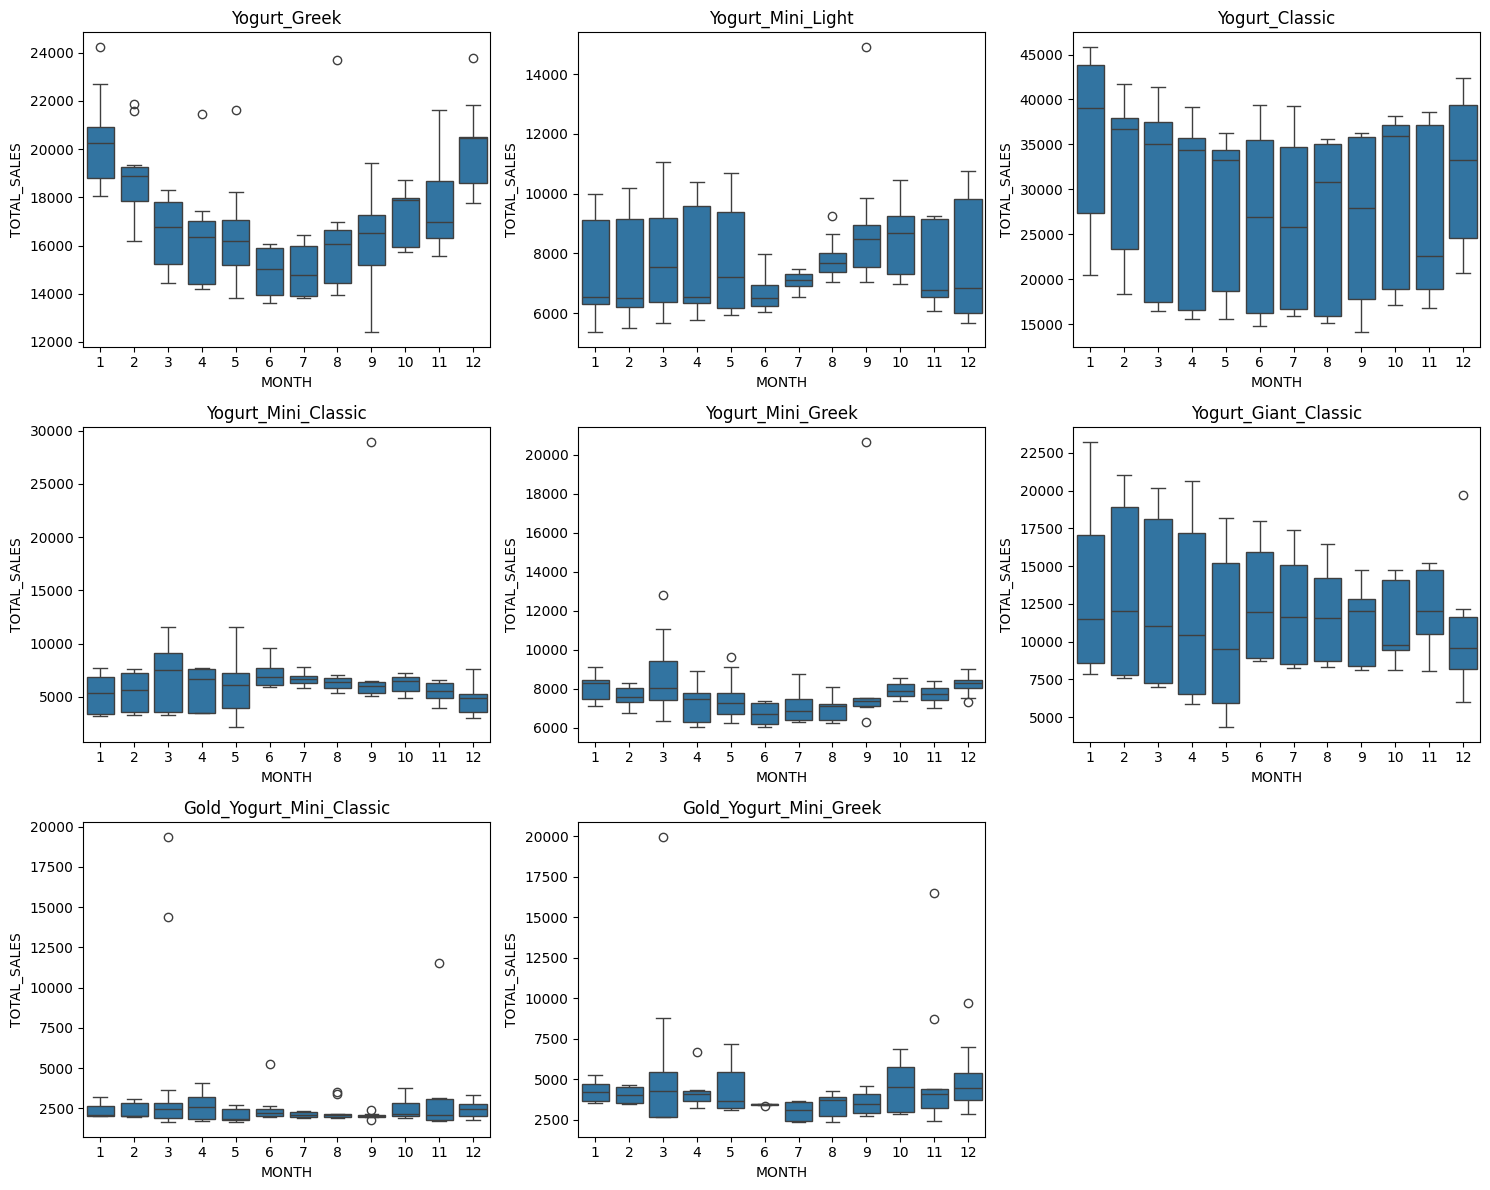

In [548]:
# boxplot of TOTAL_SALES by MONTH for each PRODUCT_DESC
products = df_train['PRODUCT_DESC'].unique()
n_products = len(products)

n_cols = 3
n_rows = math.ceil(n_products / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='MONTH',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('MONTH')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

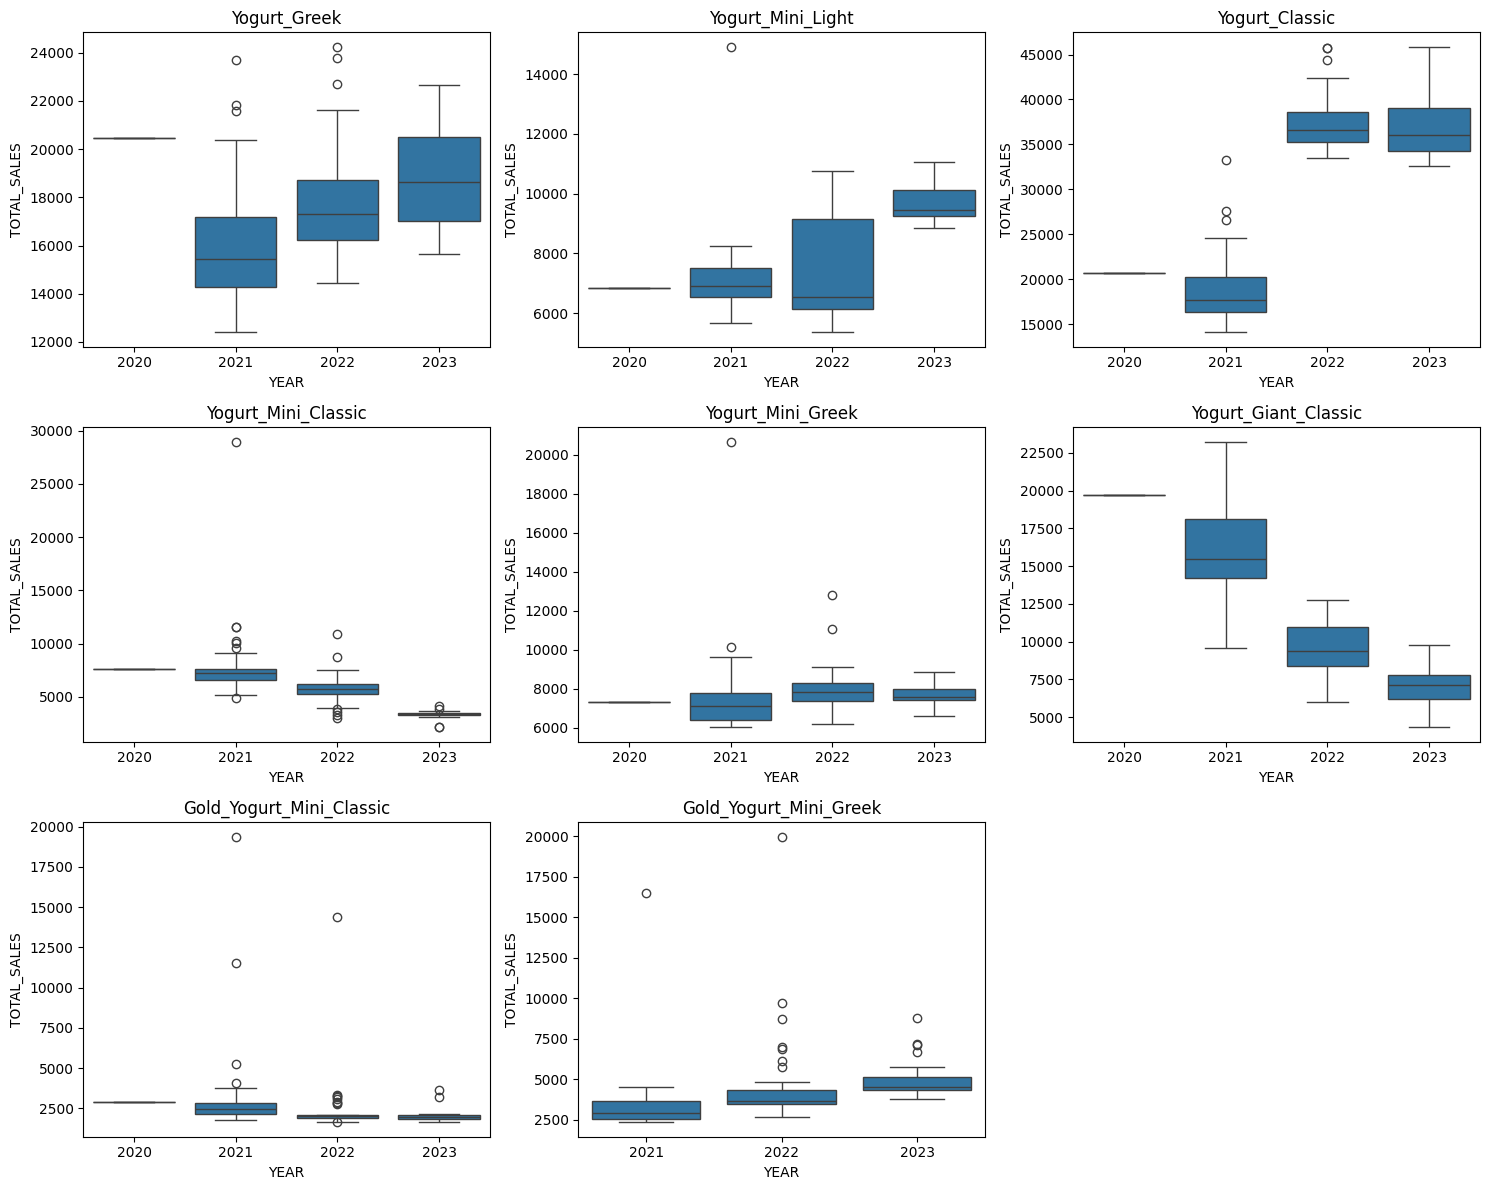

In [549]:
# boxplot of TOTAL_SALES by YEAR for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='YEAR',
        y='TOTAL_SALES',
        data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(product)
    ax.set_xlabel('YEAR')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

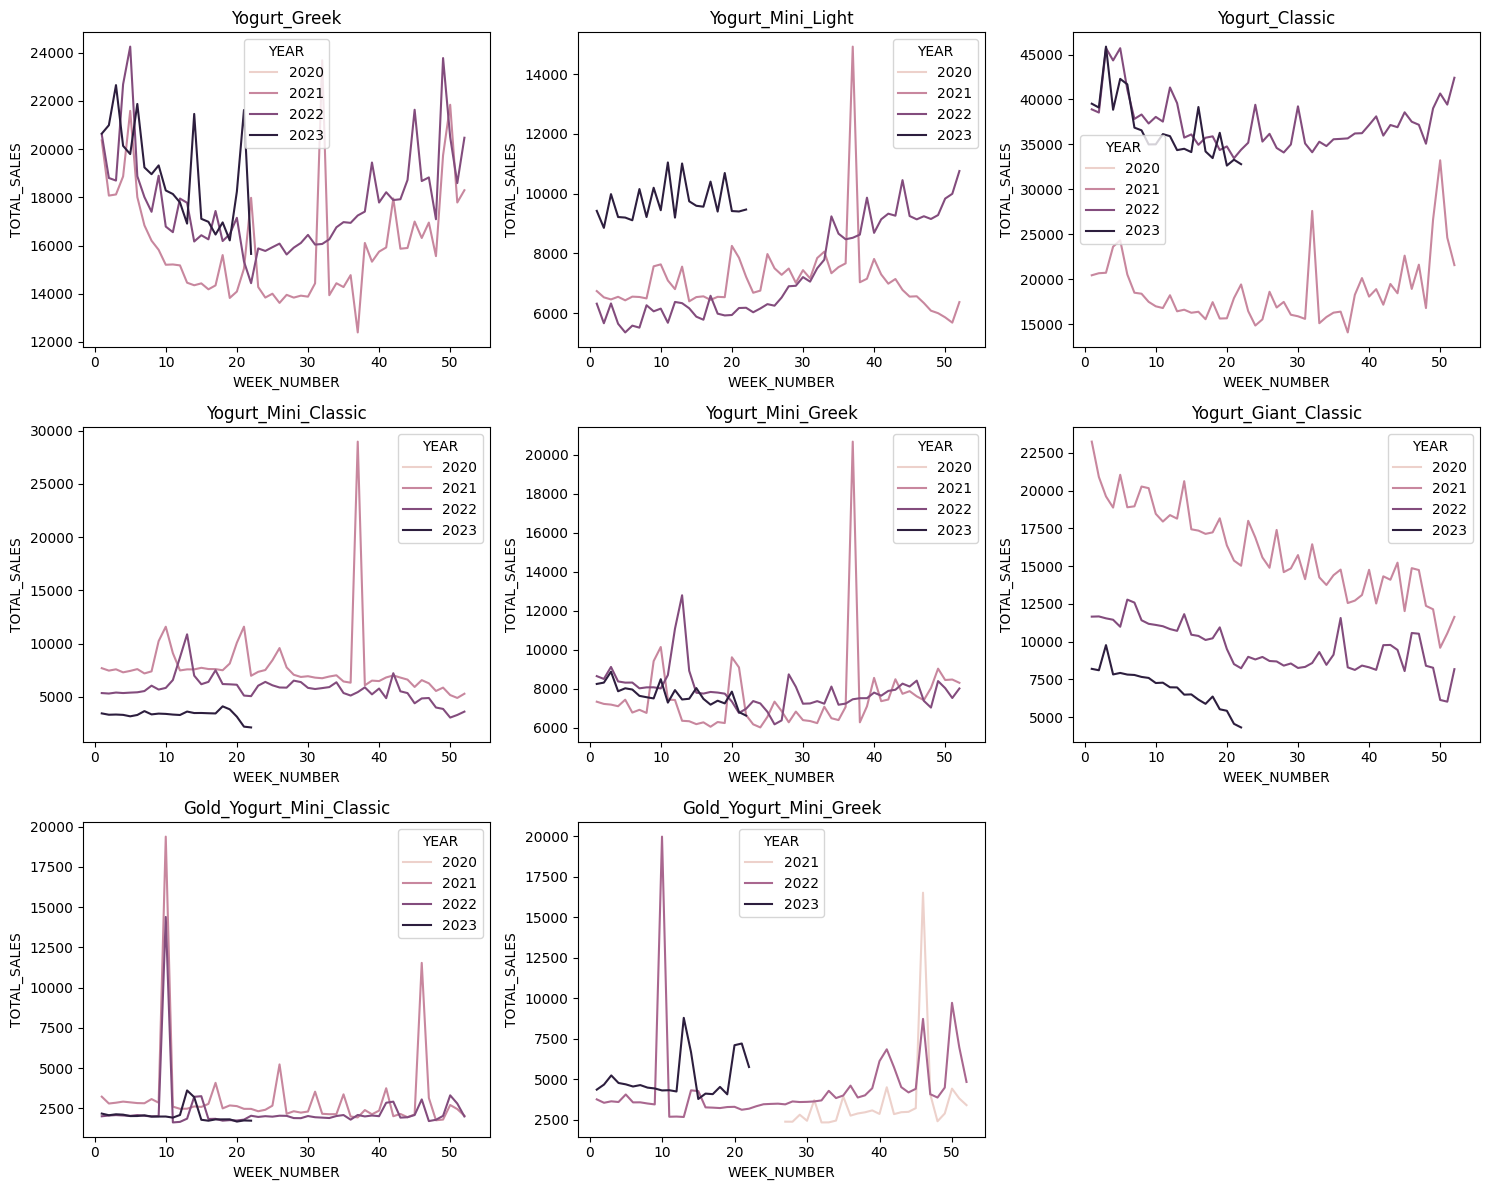

In [550]:
# lineplot of TOTAL_SALES over time for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.lineplot(
        x='WEEK_NUMBER',
        y='TOTAL_SALES',
         hue='YEAR',
         data=df_train[df_train['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('WEEK_NUMBER')
    ax.set_ylabel('TOTAL_SALES')
    ax.legend(title='YEAR')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

After plotting, since we have the transformed version of WEEK_NUMBER, MONTH, and SEASON, they are redundunt and we eliminate them.

In [551]:
df_train.drop(columns=['PRODUCT_DESC', 'WEEK_NUMBER', 'MONTH', 'SEASON'], inplace=True, axis = 1)
df_test.drop(columns=['PRODUCT_DESC', 'WEEK_NUMBER', 'MONTH', 'SEASON', 'TOTAL_SALES'], inplace=True, axis = 1)

In [552]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, 0 to 988
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   PRODUCT_ID            989 non-null    category      
 1   DATE                  989 non-null    datetime64[ns]
 2   TOTAL_SALES           989 non-null    float64       
 3   PRICE                 989 non-null    float64       
 4   IS_INDEPENDENCE_DAY   989 non-null    bool          
 5   IS_PRE_CHRISTMAS      989 non-null    bool          
 6   IS_SUPER_BOWL_SUNDAY  989 non-null    bool          
 7   IS_PRE_THANKSGIVING   989 non-null    bool          
 8   IS_EASTER_SUNDAY      989 non-null    bool          
 9   IS_LABOR_DAY          989 non-null    bool          
 10  IS_MEMORIAL_DAY       989 non-null    bool          
 11  IS_THANKSGIVING       989 non-null    bool          
 12  IS_CHRISTMAS_DAY      989 non-null    bool          
 13  PROMO_LEVEL           989

In [553]:
df_train = df_train[df_train['LAG_52'].notna()].copy()

In [554]:
df_train.head()

,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
52,3450014449,2021-12-27,18294.990367,5.668695,False,False,False,False,False,False,...,6.123234e-17,17785.476704,15559.351357,20461.337740,18733.604558,2687.636463,17636.338921,2142.860076,16066.859886,2423.677770
53,3450014449,2022-01-03,20608.710555,5.667276,False,False,False,False,False,False,...,6.123234e-17,18294.990367,19746.385178,20366.054602,19417.514311,1818.033562,17935.998399,2029.622966,16025.199359,2364.557701
54,3450014449,2022-01-10,18803.285939,5.665786,False,False,False,False,False,False,...,6.123234e-17,20608.710555,21843.204994,18072.334581,19633.095655,1918.387280,18387.798385,2186.295444,16029.865820,2373.514840
55,3450014449,2022-01-17,18696.075088,5.666745,False,False,False,False,False,False,...,6.123234e-17,18803.285939,17785.476704,18119.333530,18873.115891,1229.410859,18699.205869,2019.448885,16043.922577,2387.968671
56,3450014449,2022-01-24,22693.475673,4.967336,False,False,False,False,False,False,...,6.123234e-17,18696.075088,18294.990367,18867.597360,19100.765487,1028.824616,18917.185023,1894.172410,16055.013760,2399.110533


In [555]:
df_test.head()

,PRODUCT_ID,DATE,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
989,3450014449,2023-06-05,6.176142,False,False,False,False,False,False,False,...,-1.836970e-16,15652.010423,16212.424559,15879.049316,17932.047863,2701.59473,17404.516966,1865.892157,18200.505108,2057.691943
990,3450014449,2023-06-12,6.176059,False,False,False,False,False,False,False,...,-1.836970e-16,NaN,18237.545894,15774.108553,NaN,NaN,NaN,NaN,NaN,NaN
991,3450014449,2023-06-19,6.175545,False,False,False,False,False,False,False,...,-1.836970e-16,NaN,21626.210578,15929.710120,NaN,NaN,NaN,NaN,NaN,NaN
992,3450014449,2023-06-26,6.178684,True,False,False,False,False,False,False,...,-1.836970e-16,NaN,15652.010423,16078.193544,NaN,NaN,NaN,NaN,NaN,NaN
993,3450014449,2023-07-03,6.176310,True,False,False,False,False,False,False,...,-1.836970e-16,NaN,NaN,15626.911843,NaN,NaN,NaN,NaN,NaN,NaN


In [556]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 52 to 988
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   PRODUCT_ID            573 non-null    category      
 1   DATE                  573 non-null    datetime64[ns]
 2   TOTAL_SALES           573 non-null    float64       
 3   PRICE                 573 non-null    float64       
 4   IS_INDEPENDENCE_DAY   573 non-null    bool          
 5   IS_PRE_CHRISTMAS      573 non-null    bool          
 6   IS_SUPER_BOWL_SUNDAY  573 non-null    bool          
 7   IS_PRE_THANKSGIVING   573 non-null    bool          
 8   IS_EASTER_SUNDAY      573 non-null    bool          
 9   IS_LABOR_DAY          573 non-null    bool          
 10  IS_MEMORIAL_DAY       573 non-null    bool          
 11  IS_THANKSGIVING       573 non-null    bool          
 12  IS_CHRISTMAS_DAY      573 non-null    bool          
 13  PROMO_LEVEL           57

In [557]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 989 to 1404
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   PRODUCT_ID            416 non-null    category      
 1   DATE                  416 non-null    datetime64[ns]
 2   PRICE                 416 non-null    float64       
 3   IS_INDEPENDENCE_DAY   416 non-null    bool          
 4   IS_PRE_CHRISTMAS      416 non-null    bool          
 5   IS_SUPER_BOWL_SUNDAY  416 non-null    bool          
 6   IS_PRE_THANKSGIVING   416 non-null    bool          
 7   IS_EASTER_SUNDAY      416 non-null    bool          
 8   IS_LABOR_DAY          416 non-null    bool          
 9   IS_MEMORIAL_DAY       416 non-null    bool          
 10  IS_THANKSGIVING       416 non-null    bool          
 11  IS_CHRISTMAS_DAY      416 non-null    bool          
 12  PROMO_LEVEL           416 non-null    int64         
 13  PRICE_MEAN            

## Preparing dataset for training
Splitting the dataset into training and test dataset. Standardizing numerical feature in order to enable better performances of our regression model.

In [558]:
X = df_train.drop(columns=['TOTAL_SALES']) # dropping non-numeric and target columns
y = df_train['TOTAL_SALES']

In [559]:
X["YEAR"].unique()

array([2021, 2022, 2023], dtype=int32)

In [560]:
train_mask = X["YEAR"].isin(X["YEAR"].unique())
valid_mask = X["YEAR"] == 2023

X_train = X[train_mask]
X_valid = X[valid_mask]

y_train = y[train_mask]
y_valid = y[valid_mask]

In [561]:
#be carefull, we consider the first 80% of week for the training set and the remaining 20% for the validation set
#split_date = X["YEAR"].quantile(0.8)

#train_mask = X["YEAR"] <= split_date
#valid_mask = X["YEAR"] > split_date

#X_train = X[train_mask]
#X_test = X[valid_mask]
#y_train = y[train_mask]
#y_test = y[valid_mask]

In [562]:
X_test = df_test.copy()
# we don't have y_test yet

In [563]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((573, 31), (573,), (176, 31), (176,))

In [564]:
X_train

,PRODUCT_ID,DATE,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
52,3450014449,2021-12-27,5.668695,False,False,False,False,False,False,False,...,6.123234e-17,17785.476704,15559.351357,20461.337740,18733.604558,2687.636463,17636.338921,2142.860076,16066.859886,2423.677770
53,3450014449,2022-01-03,5.667276,False,False,False,False,False,False,False,...,6.123234e-17,18294.990367,19746.385178,20366.054602,19417.514311,1818.033562,17935.998399,2029.622966,16025.199359,2364.557701
54,3450014449,2022-01-10,5.665786,False,False,False,False,False,False,False,...,6.123234e-17,20608.710555,21843.204994,18072.334581,19633.095655,1918.387280,18387.798385,2186.295444,16029.865820,2373.514840
55,3450014449,2022-01-17,5.666745,False,False,False,False,False,False,False,...,6.123234e-17,18803.285939,17785.476704,18119.333530,18873.115891,1229.410859,18699.205869,2019.448885,16043.922577,2387.968671
56,3450014449,2022-01-24,4.967336,False,False,False,False,False,False,False,...,6.123234e-17,18696.075088,18294.990367,18867.597360,19100.765487,1028.824616,18917.185023,1894.172410,16055.013760,2399.110533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984,767707013501,2023-05-01,10.471563,False,False,False,False,False,False,False,...,-1.000000e+00,4080.513635,6676.874886,3221.120335,4663.199567,1350.685348,5040.541350,1764.867733,4561.316717,1437.823750
985,767707013501,2023-05-08,10.470809,False,False,False,False,False,False,False,...,-1.000000e+00,4526.880154,3782.211328,3284.064116,4125.700884,306.119846,5067.680319,1753.658761,4586.427482,1425.306743
986,767707013501,2023-05-15,8.898747,False,False,False,False,False,False,False,...,-1.000000e+00,4068.434084,4113.198418,3298.080651,4197.256573,220.561122,5035.731413,1771.381131,4601.511520,1415.369419
987,767707013501,2023-05-22,8.528420,False,False,False,False,False,False,True,...,-1.000000e+00,7103.048795,4080.513635,3116.434935,4944.719167,1454.613691,5393.006900,1874.325451,4674.683985,1444.714084


In [565]:
num_cols = ['PRICE']

#scaler = StandardScaler()
#X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
#X_test[num_cols] = scaler.transform(X_test[num_cols])

## Creating the Regression Model
We're gonna use XGBoost for this regression task.

In [ ]:
# creating model
base_est = xgb.XGBRegressor(tree_method='hist', random_state=42)


param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}


'''
param_grid = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [ 2,3,4],
    "min_child_weight": [1, 3, 5],
    "subsample": [ 0.8, 1.0],
    "colsample_bytree": [ 0.8, 1.0],
    "gamma": [0, 0.3, 0.5],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 1.5, 2]
}
'''

gscv = GridSearchCV(estimator=base_est,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=5, # 5-fold cross-validation
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_params)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score:  8757525.925484275


## Note:
- Should I convert BOOLEAN COLUMNS to int?
- Check what GPT is saying about the project. Why is RMSE so high rn?
- Remember to use MAPE as scoring!!